# Pillar of credit chain:

- Prospection;
- Concession;
- Risk management;
- Recovery.

The focus of this course is on the concession pillar.

## Credit chain:
The credit chain is the process of granting credit to a customer. And it is composed of three agents:

- The savers;
- The financial intermediaries;
- The borrowers.

## Credit scoring:

Credit scoring is the process of evaluating the creditworthiness of a customer. This is a probability, then the value is between 0 and 1.  And it is composed of three steps:
- Data collection;
- Data analysis;
- Decision making.

## Credit risk:

Credit risk is the risk of loss due to a borrower's default on a loan or other line of credit.


# Importing libraries

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,  confusion_matrix, ConfusionMatrixDisplay, classification_report,roc_curve, roc_auc_score

In [47]:
SEED = 42

# Reading the data

In [48]:
df_german_credit = pd.read_csv('../data/statlog_german_credit/german_credit.csv')
df_german_credit.head(3)

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes


In [49]:
df_german_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   default                     1000 non-null   int64 
 1   account_check_status        1000 non-null   object
 2   duration_in_month           1000 non-null   int64 
 3   credit_history              1000 non-null   object
 4   purpose                     1000 non-null   object
 5   credit_amount               1000 non-null   int64 
 6   savings                     1000 non-null   object
 7   present_emp_since           1000 non-null   object
 8   installment_as_income_perc  1000 non-null   int64 
 9   personal_status_sex         1000 non-null   object
 10  other_debtors               1000 non-null   object
 11  present_res_since           1000 non-null   int64 
 12  property                    1000 non-null   object
 13  age                         1000 non-null   int64

In [50]:
lines_size, columns_size = df_german_credit.shape
lines_size, columns_size

(1000, 21)

In [51]:
duplicate_lines = df_german_credit.duplicated()
print(f'The dataset has {duplicate_lines.sum()} duplicated lines.')

The dataset has 0 duplicated lines.


In [52]:
empty_values = df_german_credit.isnull()
empty_values.sum()

default                       0
account_check_status          0
duration_in_month             0
credit_history                0
purpose                       0
credit_amount                 0
savings                       0
present_emp_since             0
installment_as_income_perc    0
personal_status_sex           0
other_debtors                 0
present_res_since             0
property                      0
age                           0
other_installment_plans       0
housing                       0
credits_this_bank             0
job                           0
people_under_maintenance      0
telephone                     0
foreign_worker                0
dtype: int64

# Logistic regression

## Data categorization

In [53]:
def categorization_data(df, column_name):
    series_categorized = pd.Categorical(
        df[column_name],
        ordered=False
    )
    series_droped_duplicates = df[column_name].drop_duplicates()
    data_categorized_code = {column_name: {}}

    for index_info in series_droped_duplicates.index:
        data_categorized_code[column_name].update(
            {
                series_categorized.codes[index_info]: series_droped_duplicates[index_info]
            }
        )
    return series_categorized.codes, data_categorized_code

In [54]:
object_columns = df_german_credit.select_dtypes(include=['object']).columns
data_categorized_code_complete = {}

for column_name in object_columns:
    df_german_credit[column_name], data_categorized_code = categorization_data(
        df_german_credit, column_name)
    data_categorized_code_complete.update(data_categorized_code)

df_german_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   default                     1000 non-null   int64
 1   account_check_status        1000 non-null   int8 
 2   duration_in_month           1000 non-null   int64
 3   credit_history              1000 non-null   int8 
 4   purpose                     1000 non-null   int8 
 5   credit_amount               1000 non-null   int64
 6   savings                     1000 non-null   int8 
 7   present_emp_since           1000 non-null   int8 
 8   installment_as_income_perc  1000 non-null   int64
 9   personal_status_sex         1000 non-null   int8 
 10  other_debtors               1000 non-null   int8 
 11  present_res_since           1000 non-null   int64
 12  property                    1000 non-null   int8 
 13  age                         1000 non-null   int64
 14  other_ins

## Split data between modelling (x) and response (y)

In [55]:
x, y = df_german_credit.drop(columns=['default']), df_german_credit['default']
print(f'data complete shape: {df_german_credit.shape} | x shape: {x.shape} | y shape: {y.shape}')

data complete shape: (1000, 21) | x shape: (1000, 20) | y shape: (1000,)


## Split data between training and testing

In [56]:
x_train, x_test, y_train, y_test = train_test_split(
    x, y,
    test_size=0.3,
    random_state=SEED
)
print(
    f'The train dataset has {x_train.shape[0]} lines and the test dataset has {x_test.shape[0]} lines.')

The train dataset has 700 lines and the test dataset has 300 lines.


## Define the model

In [57]:
def build_model(x_train, y_train):
    model = LogisticRegression(
        max_iter=1_000,
        random_state=SEED
    )
    model.fit(x_train, y_train)
    return model

In [58]:
model_lr = build_model(x_train, y_train)


In [59]:
f'The model score is {model_lr.score(x_train, y_train):.2%}'

'The model score is 73.14%'

In [60]:
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
kf.get_n_splits(x)

for i, (train_index, test_index) in enumerate(kf.split(x)):
    print(f"Fold {i}:")
    x_train_kf, x_test_kf, y_train_kf, y_test_kf = (
        x.loc[train_index],
        x.loc[test_index],
        y.loc[train_index],
        y.loc[test_index]
    )
    model_lr_kf = build_model(x_train_kf, y_train_kf)
    print(
        f'The model score is {model_lr_kf.score(x_train_kf, y_train_kf):.2%}')

Fold 0:
The model score is 73.62%
Fold 1:
The model score is 74.50%
Fold 2:
The model score is 74.50%
Fold 3:
The model score is 73.12%
Fold 4:
The model score is 74.50%


In [61]:
predicts = model_lr.predict(x_test)
predicts

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], d

In [62]:
accuracy_model = accuracy_score(y_test, predicts)
print(f'The model accuracy is {accuracy_model:.2%}')

The model accuracy is 71.33%


## Confusion matrix

The confusion matrix is a table that is often used to describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known. It allows the visualization of the performance of an algorithm. The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix. The confusion matrix is split into four quadrants:
- True Positive (TP): The model correctly predicts the positive class as positive.
- False Positive (FP): The model incorrectly predicts the negative class as positive.
- True Negative (TN): The model correctly predicts the negative class as negative.
- False Negative (FN): The model incorrectly predicts the positive class as negative.

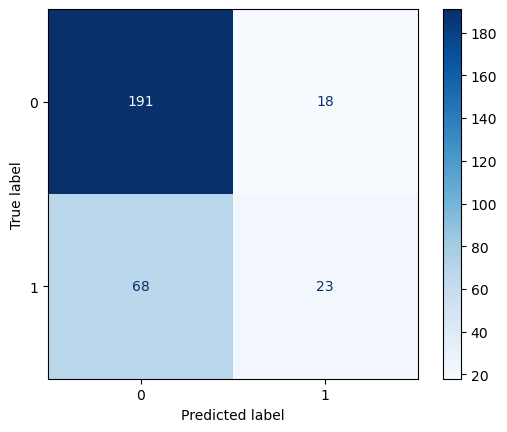

In [63]:
# confusion_matrix = plot_confusion_matrix(model_lr, x_test, y_test,cmap=plt.cm.Blues,values_format='.3g') # Old version

confusion_matrix_model = confusion_matrix(y_test, predicts)
display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix_model, display_labels=model_lr.classes_)
display_confusion_matrix.plot(cmap=plt.cm.Blues,values_format='.3g')


## Classification report

In [64]:
classification_report_model = classification_report(y_test, predicts)
print(classification_report_model)

              precision    recall  f1-score   support

           0       0.74      0.91      0.82       209
           1       0.56      0.25      0.35        91

    accuracy                           0.71       300
   macro avg       0.65      0.58      0.58       300
weighted avg       0.68      0.71      0.67       300



## ROC curve

In [65]:
# [:,1] -> Probabilities of the class 1
probabilities_model = model_lr.predict_proba(x_test)[:, 1]  
# tfp -> False Positive Rate, tvp -> True Positive Rate
tfp, tvp, thresholds = roc_curve(y_test, probabilities_model)
print(f'The AUC score is {roc_auc_score(y_test, probabilities_model):.2%}')

The AUC score is 71.58%


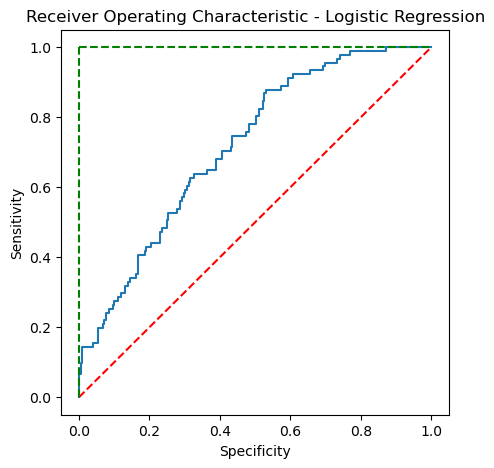

In [66]:
plt.subplots(1, figsize=(5, 5))
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.plot(tfp, tvp)
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.plot([0, 1], ls="--", c="red")
plt.plot([0, 0], [1, 0], ls="--", c="green")
plt.plot([1, 1], ls="--", c="green")
plt.show()

## Describe analysis

In [67]:
data_categorized_code_complete.get('personal_status_sex')



{3: 'male : single',
 0: 'female : divorced/separated/married',
 1: 'male : divorced/separated',
 2: 'male : married/widowed'}

In [68]:
variables_analysis = [
    item 
    for item in df_german_credit.columns 
    if item not in object_columns
    ]

df_german_credit[variables_analysis].describe()

,default,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.300000,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,0.458487,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,0.000000,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,0.000000,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,0.000000,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,1.000000,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,1.000000,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


In [69]:
df_german_credit['personal_status_sex'].replace(
    data_categorized_code_complete.get('personal_status_sex')).value_counts().sort_index()

female : divorced/separated/married    310
male : divorced/separated               50
male : married/widowed                  92
male : single                          548
Name: personal_status_sex, dtype: int64

In [70]:
# Our dataset is unbalanced
df_german_credit['default'].value_counts().sort_index()

0    700
1    300
Name: default, dtype: int64

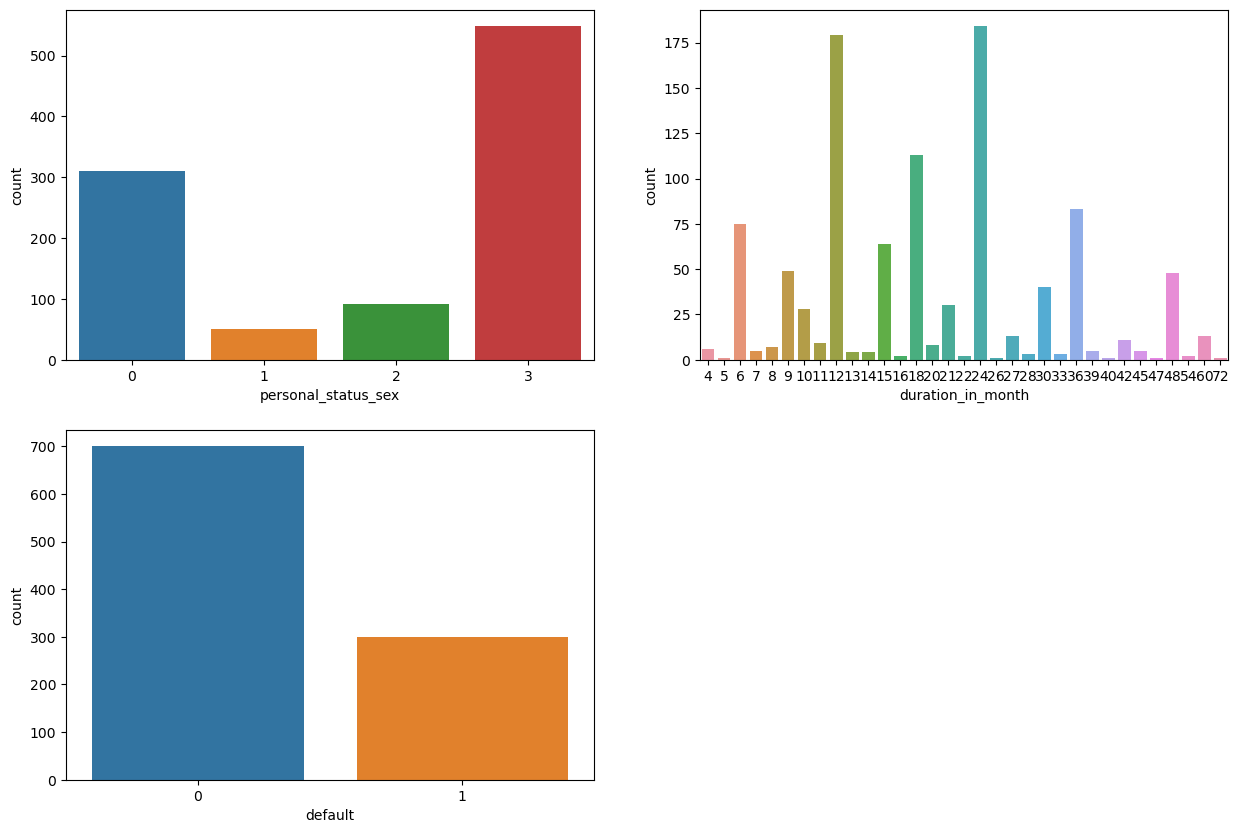

In [71]:
histograms = ['personal_status_sex', 'duration_in_month', 'default']

plt.figure(figsize=(15, 10))
for histogram in list(enumerate(histograms)):
    plt.subplot(2, 2, histogram[0]+1)
    sns.countplot(x=histogram[1], data=df_german_credit)

<AxesSubplot:xlabel='personal_status_sex', ylabel='age'>

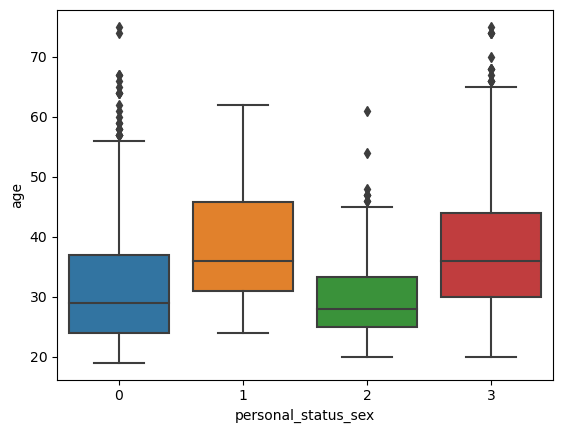

In [72]:
sns.boxplot(x='personal_status_sex',
            y='age', data=df_german_credit)

<AxesSubplot:xlabel='duration_in_month', ylabel='credit_amount'>

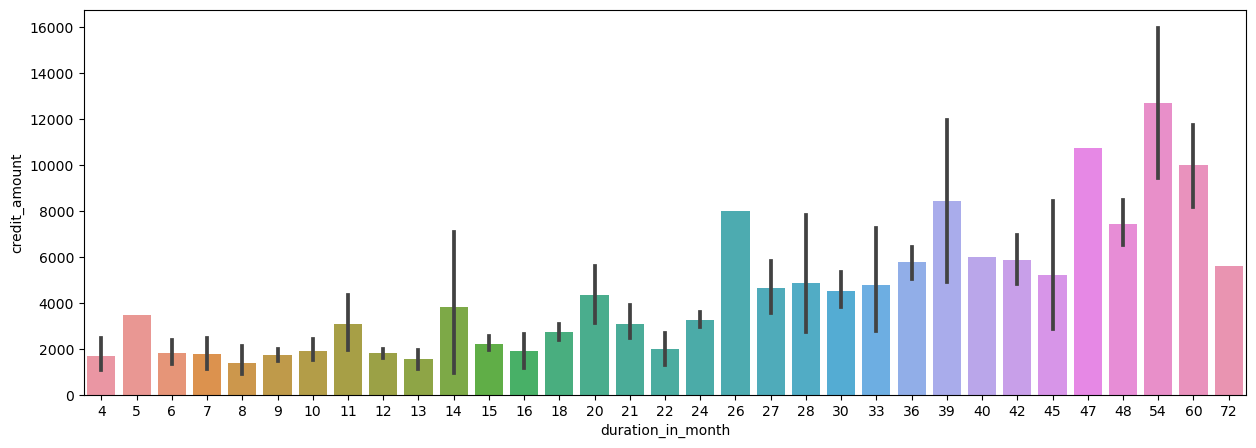

In [73]:
plt.figure(figsize=(15, 5))
sns.barplot(x='duration_in_month', y='credit_amount',data=df_german_credit)

In [75]:
split_personal_status = {
    0: 0,  # 'divorced/separated/married'
    1: 1,  # 'divorced/separated'
    2: 0,  # 'married/widowed'
    3: 1,  # 'single'
}
split_sex = {
    0: 0,  # 'female'
    1: 1,  # 'male'
    2: 1,  # 'male'
    3: 1,  # 'male'
}

df_german_credit['personal_status'] = df_german_credit['personal_status_sex'].replace(
    split_personal_status)
df_german_credit['sex'] = df_german_credit['personal_status_sex'].replace(
    split_sex)

display(df_german_credit[['personal_status', 'sex']].describe())
display(df_german_credit['personal_status'].value_counts().sort_index())
display(df_german_credit['sex'].value_counts().sort_index())

,personal_status,sex
count,1000.000000,1000.000000
mean,0.598000,0.690000
std,0.490547,0.462725
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,1.000000
75%,1.000000,1.000000
max,1.000000,1.000000


0    402
1    598
Name: personal_status, dtype: int64

0    310
1    690
Name: sex, dtype: int64

In [89]:
def run_model(data_base,classificator):
    x, y = data_base.drop(columns=['default']), data_base['default']
    x_train, x_test, y_train, y_test = train_test_split(
        x, y,
        test_size=0.3,
        random_state=SEED
    )
    print(
        f'The train dataset has {x_train.shape[0]} lines and the test dataset has {x_test.shape[0]} lines.')
    model = classificator.fit(x_train, y_train)

    predicts = model.predict(x_test)
    confusion_matrix_model = confusion_matrix(y_test, predicts)
    display_confusion_matrix = ConfusionMatrixDisplay(confusion_matrix_model, display_labels=model_lr.classes_)
 
    display_confusion_matrix.plot(cmap=plt.cm.Blues,values_format='.3g')
    plt.title('Confusion Matrix')
    plt.show()
    print(f'Classisication Report: \n {classification_report(y_test, predicts)}')

    probabilities_model = model.predict_proba(x_test)[:, 1]
    tfp, tvp, thresholds = roc_curve(y_test, probabilities_model)
    print(f'The AUC score is {roc_auc_score(y_test, probabilities_model):.2%}')

    plt.subplots(1, figsize=(5, 5))
    plt.title('RoC Curve')
    plt.plot(tfp, tvp)
    plt.xlabel('Specificity')
    plt.ylabel('Sensitivity')
    plt.plot([0, 1], ls="--", c="red")
    plt.plot([0, 0], [1, 0], ls="--", c="green")
    plt.plot([1, 1], ls="--", c="green")
    plt.show()
    

    print(100*'-')
     
    return model, confusion_matrix_model

The train dataset has 700 lines and the test dataset has 300 lines.


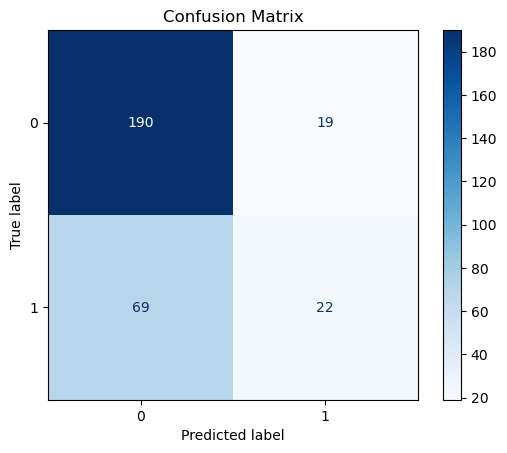

Classisication Report: 
               precision    recall  f1-score   support

           0       0.73      0.91      0.81       209
           1       0.54      0.24      0.33        91

    accuracy                           0.71       300
   macro avg       0.64      0.58      0.57       300
weighted avg       0.67      0.71      0.67       300

The AUC score is 71.68%


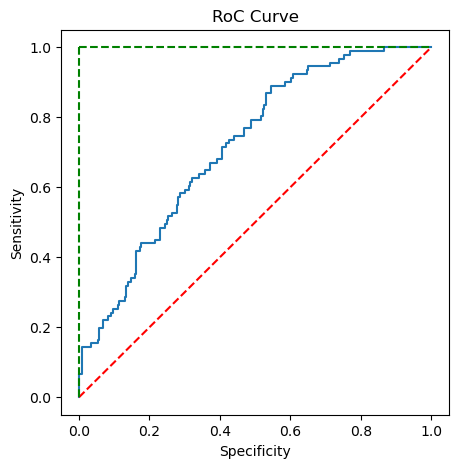

----------------------------------------------------------------------------------------------------


(LogisticRegression(max_iter=1000),
 array([[190,  19],
        [ 69,  22]], dtype=int64))

In [90]:
run_model(df_german_credit, LogisticRegression(max_iter=1_000))